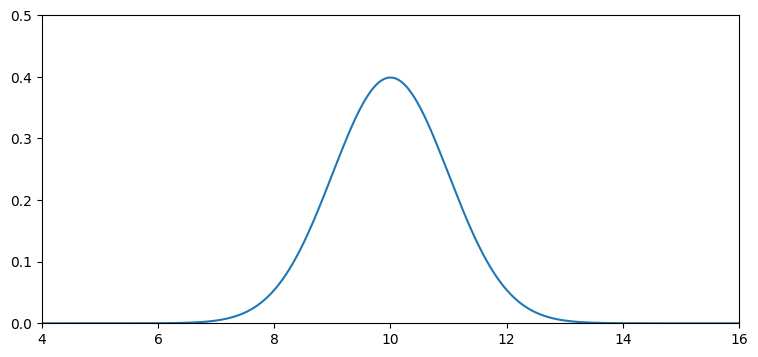

In [1]:
%matplotlib inline

#format the book
import book_format
book_format.set_style()

import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

Mean of readings is 9.959


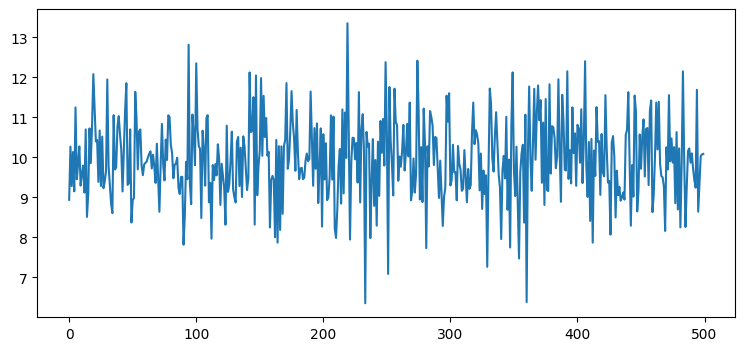

In [2]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

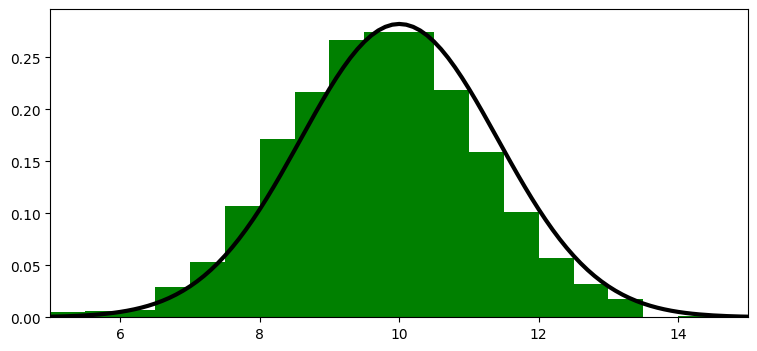

In [4]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

In [6]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: f'𝒩(μ={s[0]:.3f}, 𝜎²={s[1]:.3f})'

g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [7]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

In [8]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

# test the update function
predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

𝒩(μ=10.000, 𝜎²=0.500)


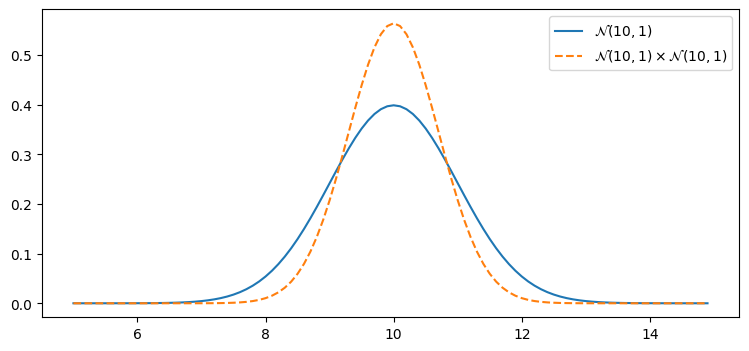

In [9]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

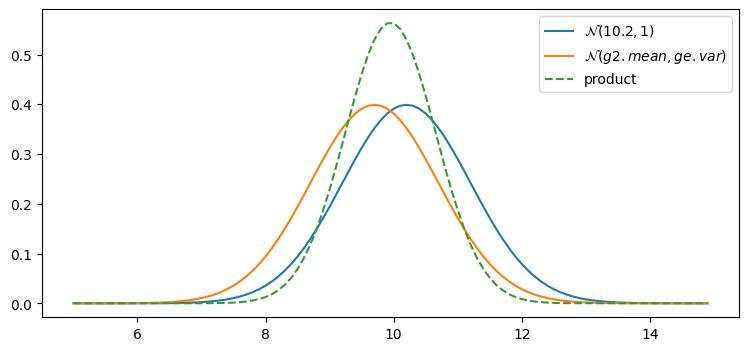

In [10]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + f'$({g1.mean},{g1.var})$')

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$' + '$({g2.mean},{ge.var})$')

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    plt.show()
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

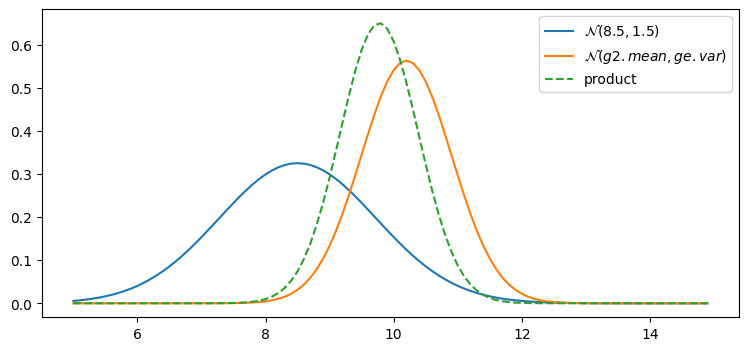

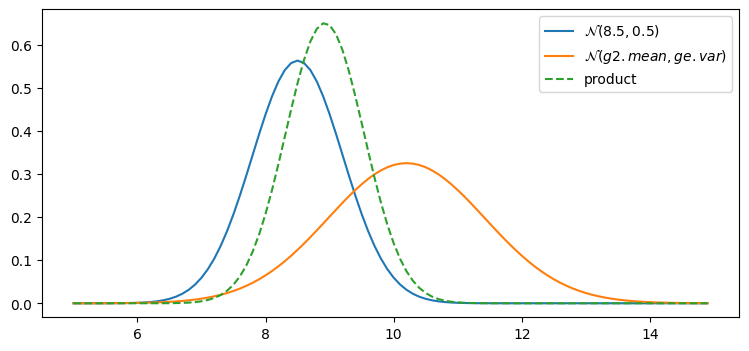

In [11]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

In [12]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

interactive(children=(FloatSlider(value=7.5, description='m1', max=10.0, min=5.0, step=0.5), FloatSlider(value…

In [14]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import DogSimulation

np.random.seed(13)

process_var = 1. # variance in the dog's movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # dog's position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
dog = DogSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [dog.move_and_sense() for _ in range(10)]

print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print(f'final estimate:        {x.mean:10.3f}')
print(f'actual final position: {dog.x:10.3f}')

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


In [15]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])
    
    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
    plt.show()
    
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

interactive(children=(IntSlider(value=1, description='step', max=30, min=1), Output()), _dom_classes=('widget-…

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


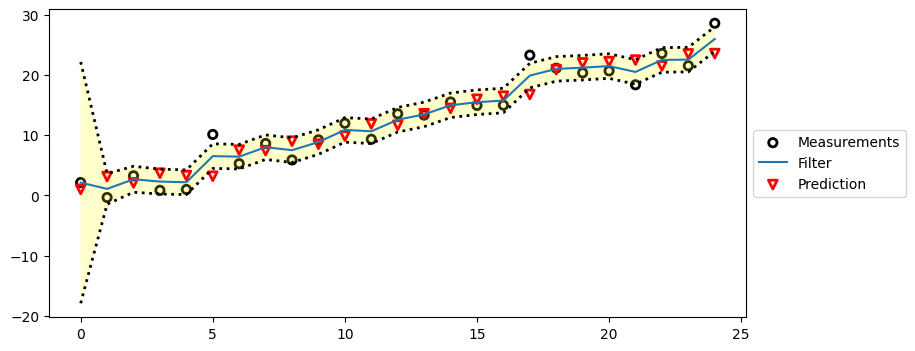

In [16]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

dog = DogSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

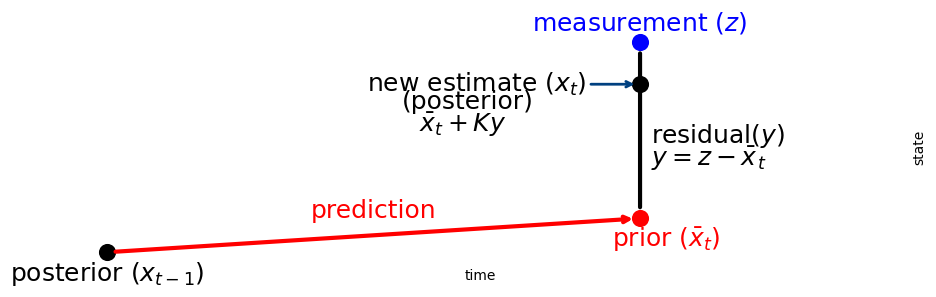

In [17]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

In [18]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

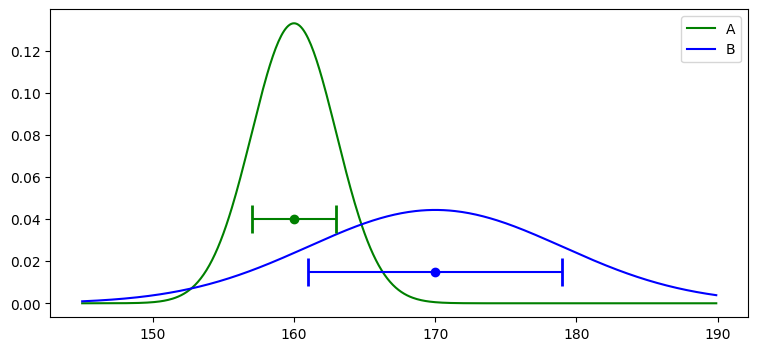

In [19]:
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
plt.plot(xs, ys, label='A', color='g')

ys = [stats.gaussian(x, 170, 9**2) for x in xs]
plt.plot(xs, ys, label='B', color='b')
plt.legend();
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='g', capthick=2, capsize=10)    
plt.errorbar(170, [0.015], xerr=[9], fmt='o', color='b', capthick=2, capsize=10);

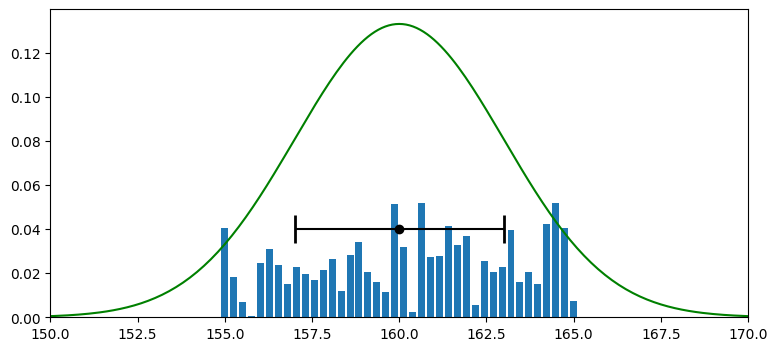

In [20]:
from random import random
xs = np.arange(145, 190, 0.1)
ys = [stats.gaussian(x, 160, 3**2) for x in xs]
belief = np.array([random() for _ in range(40)])
belief = belief / sum(belief)

x = np.linspace(155, 165, len(belief))
plt.gca().bar(x, belief, width=0.2)
plt.plot(xs, ys, label='A', color='g')
plt.errorbar(160, [0.04], xerr=[3], fmt='o', color='k', capthick=2, capsize=10)    
plt.xlim(150, 170);

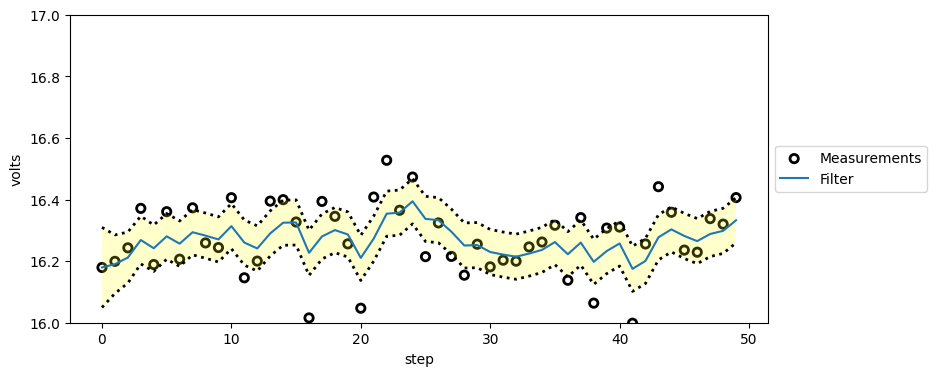

Variance converges to 0.005


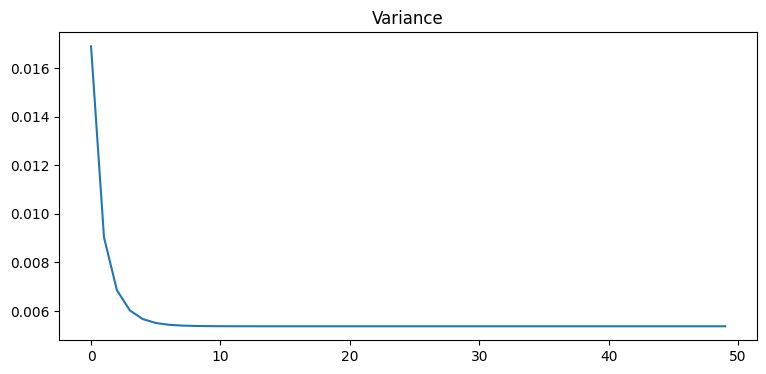

In [21]:
def volt(voltage, std):
    return voltage + (randn() * std)

temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print(f'Variance converges to {ps[-1]:.3f}')

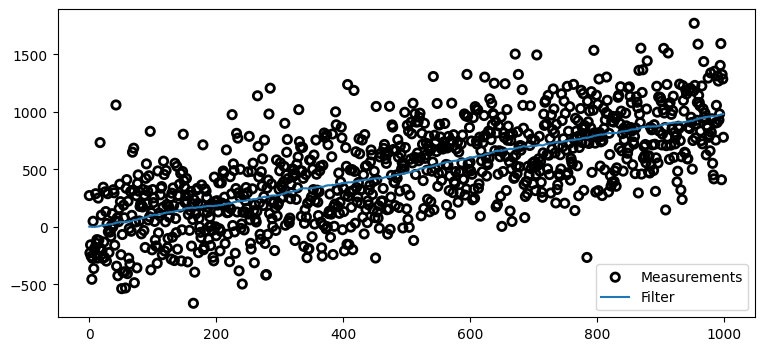

In [22]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
dog = DogSimulation(pos.mean, 1., sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

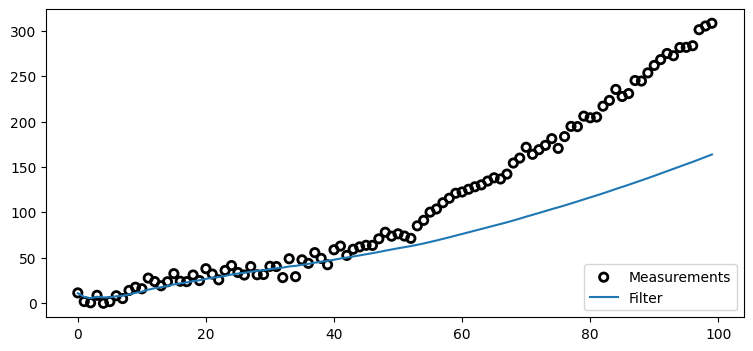

In [26]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
dog = DogSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    dog.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

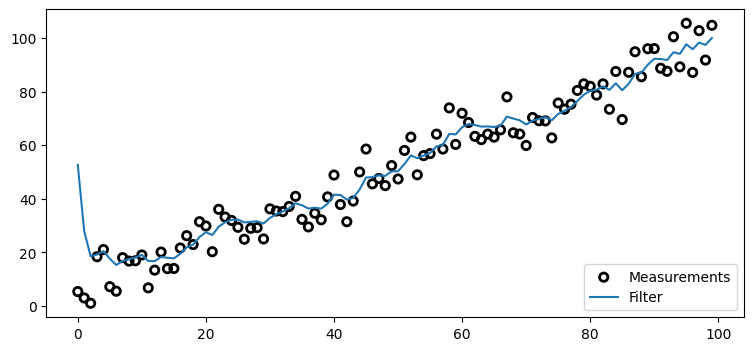

In [24]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

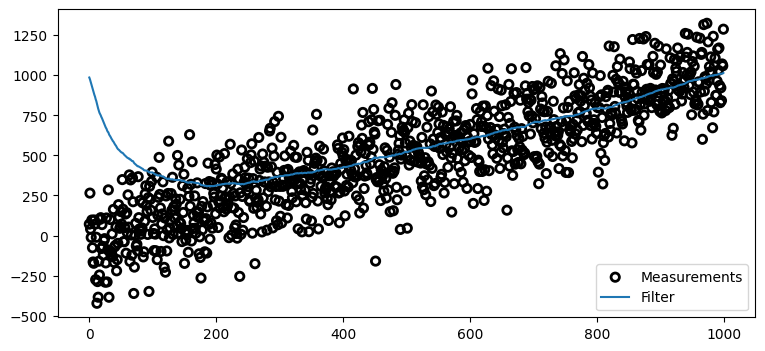

In [27]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
dog = DogSimulation(0, 1, sensor_var, process_var)
zs = [dog.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

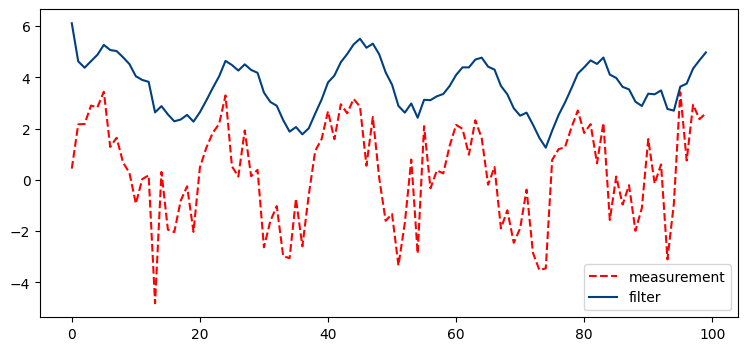

In [29]:
import math

sensor_var = 30.
process_var = 2.
pos = gaussian(100., 500.)
process_model = gaussian(1., process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');